# Attempt to integrate all datasets

In [ ]:
import sys
sys.path.append('/home/hsher/scSecretome')
from scSecretome.sc import *

# all the data
from os import listdir
file_list = listdir('/data2/hsher/nature2019_sc/raw_counts/')
# the paper contain data from two patients
sample_two = [s for s in file_list if 'Lin' in s]
sample_one = [s for s in file_list if 'Lin' not in s]

threshold = [800, 1000, 1000, 800, 2000, 1000, 2000, 800, 800, 800, 800]

import pandas as pd
thres_df = pd.DataFrame(index = sample_one + sample_two, columns = ['transcript per cell'], data = threshold)
thres_df['annotation'] = ['CMP', 'MEP', 'GMP', 'PreBNK', 'MPP', 'HSC', 'MLP', 'Lin- CD34- CD164low', 'Lin- CD34- CD164high', 'Lin- CD34+ CD164+', 'Lin- CD34low CD164high']

def filter_pellin(sample):
    '''
    input list of samples for experiment
    output combined data matrix
    '''
    d = read_raw_counts('/data2/hsher/nature2019_sc/raw_counts/'+sample)
    
    # put FACs data inside
    d.obs['cluster'] = thres_df.loc[sample, 'annotation']
        
    # filter by transcript per cell
    sc.pp.filter_cells(d, min_counts = thres_df.loc[sample, 'transcript per cell'])
        
    # called benchmarking to calculate 
    benchmarking(d)
        
    # fileter by mitochondrial trancript: dying cell
    d = d[d.obs['percent_mito']<0.25]
    
       
    # append all batch to list
    return(d)
def concat_data(sample_list):
    processed = list(map(filter_pellin, sample_list))
    concat = processed[0].concatenate(processed[1:len(processed)])
    
    #sc.pp.combat(concat)
    
    return(concat)

pellin_cd34 = concat_data(sample_one)
pellin_lin = concat_data(sample_two)

In [ ]:
def filter_wolock(filename = '/home/hsher/wolock2019_stroma/GSE132151_bone_marrow_stroma.trimmed.tsv', 
                  metadata = '/home/hsher/wolock2019_stroma/GSE132151_bone_marrow_stroma.metadata.tsv', 
                 transcript_per_cell = 500, 
                 mito = 0.2):
    # read single cell expression matrix
    wo = read_raw_counts(filename, ignore_lines = 0, transpose = False)
    
    # join original publidation's metadata (cluster assigned)
    wo_metadata = pd.read_csv(metadata, header = 0, sep = '\t', index_col = 0)
    wo.obs = wo_metadata
    
    # filter cells with no enough transcript in cell
    sc.pp.filter_cells(wo, min_counts = transcript_per_cell)
    
    # benchmarking
    benchmarking(wo, species = 'mouse')
    
    # filter mitochondrial gene
    wo = wo[ wo.obs['percent_mito']<mito ]
    
  
    return(wo)
wo = filter_wolock()

In [ ]:
def filter_tikhonova(filename,  
                 transcript_per_cell = 1000, 
                 mito = 0.1):
    # read single cell expression matrix
    base = '/data2/hsher/nature2019_mice_niche/'
    wo = read_raw_counts(base+filename, ignore_lines = 0, transpose = True)
    
        
    # filter cells with no enough transcript in cell
    sc.pp.filter_cells(wo, min_counts = transcript_per_cell)
    
    # benchmarking
    benchmarking(wo, species = 'mouse')
    
    # filter mitochondrial gene
    wo = wo[ wo.obs['percent_mito']<mito ]
    
    # normalize, by excluding frequent gene to avoid distorting data
    return(wo)
sample_three = listdir('/data2/hsher/nature2019_mice_niche/') # mice stroma data nature 2019
sample_three.remove('GSE123078_RAW.tar')
sample_three

lepr = filter_tikhonova('GSM3494769_lepr-ctrl.counts.raw.txt')
vecad = filter_tikhonova('GSM3494771_vecad-ctrl.counts.raw.txt')
lepr.obs['cluster']='lepr'
vecad.obs['cluster']='vecad'
tikhonova = lepr.concatenate(vecad)

# Map mice to human

In [ ]:
wo_mapped = mice_to_human(wo)
tik_mapped = mice_to_human(tikhonova)

# Run BBKNN

In [ ]:
concat = pellin_lin.concatenate([pellin_cd34, wo_mapped, tik_mapped], batch_key = 'dataset')
concat.obs_names_make_unique()

In [ ]:
# save raw data, normalized and log
concat.raw = sc.pp.log1p(concat, copy=True)

In [ ]:
concat.raw.var

In [ ]:
# find highly variable genes
filter_result = sc.pp.filter_genes_dispersion(
    concat.X, min_mean=0.0125, max_mean=2.5, min_disp=0.7)
sc.pl.filter_genes_dispersion(filter_result)
print([sum([i[0] for i in filter_result]),len(filter_result)])

In [ ]:
# filter and retain only the filtered result
adata = concat[:, filter_result.gene_subset]
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)
adata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
num_pcs = 8 # dtermined by elbow method

# bbknn rely on neighbors
sc.pp.neighbors(adata,n_pcs=num_pcs, n_neighbors=20)
sc.tl.umap(adata)
sc.tl.louvain(adata)



In [ ]:
# see uncorrected data
sc.pl.umap(adata, color=['dataset','louvain','cluster'])

#clear out the cluster plot colour map by hand, as otherwise it stays
del adata.uns['louvain_colors']

In [ ]:
# compar to batch effect correction
import bbknn
adata_bbknn = bbknn.bbknn(adata, batch_key='dataset', neighbors_within_batch=3, n_pcs=num_pcs, trim=0, copy=True)
sc.tl.umap(adata_bbknn)

# two clustering method
sc.tl.louvain(adata_bbknn)
sc.tl.leiden(adata_bbknn)



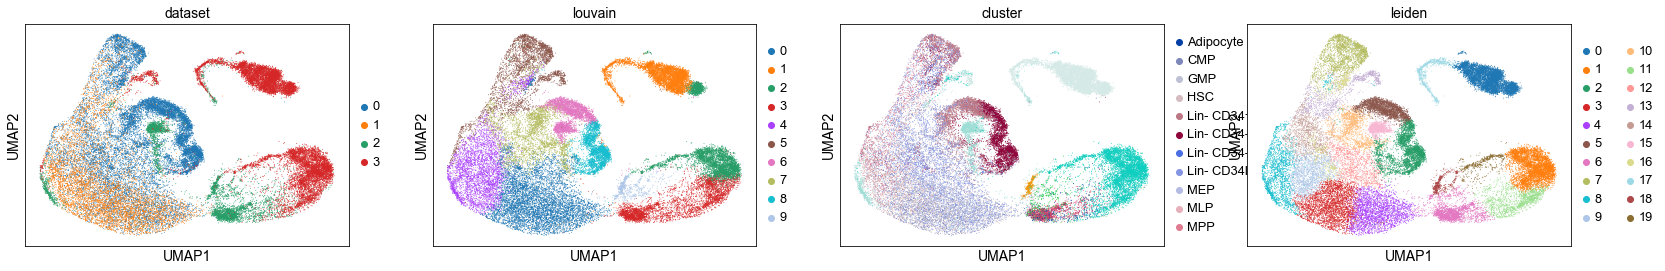

In [25]:
# use raw so that all genes are included
sc.pl.umap(adata_bbknn, color = ['dataset','louvain','cluster', 'leiden'], use_raw = True)

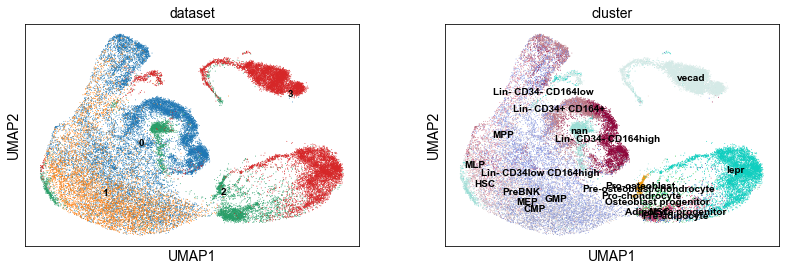

In [26]:
sc.pl.umap(adata_bbknn, color = ['dataset','cluster'], use_raw = True, legend_loc = 'on data')

In [28]:
import bbknn
adata_bbknn_2 = bbknn.bbknn(adata, batch_key='dataset', neighbors_within_batch=5, n_pcs=20, trim=0, copy=True)
sc.tl.umap(adata_bbknn_2)

# two clustering method
sc.tl.louvain(adata_bbknn_2)
sc.tl.leiden(adata_bbknn_2)


computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:49)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:06)
running Leiden clustering
    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:35)


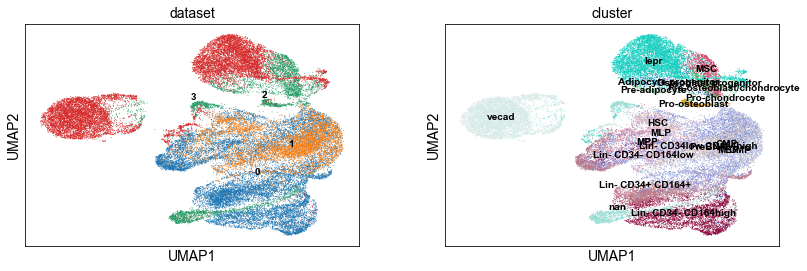

In [29]:
sc.pl.umap(adata_bbknn_2, color = ['dataset','cluster'], use_raw = True, legend_loc = 'on data')

In [32]:
adata_bbknn.obs.columns

Index(['Library', 'PBA_Adipo_pseudotime', 'PBA_Chondro_pseudotime',
       'PBA_Osteo_pseudotime', 'PBA_Potential', 'PBA_Pr_Adipo',
       'PBA_Pr_Chondro', 'PBA_Pr_Osteo', 'SPRING_x', 'SPRING_y', 'barcode',
       'batch', 'cluster', 'dataset', 'library', 'mito_frac', 'n_counts',
       'n_genes', 'pass_filter', 'percent_housekeeper', 'percent_mito',
       'sample', 'louvain', 'leiden'],
      dtype='object')

In [33]:
import sys
sys.path.append('/home/hsher/scSecretome')
from scSecretome.sc import *
from scSecretome.annot import *

In [52]:
'ANXA2' in adata_bbknn.raw.var.index.tolist()

True

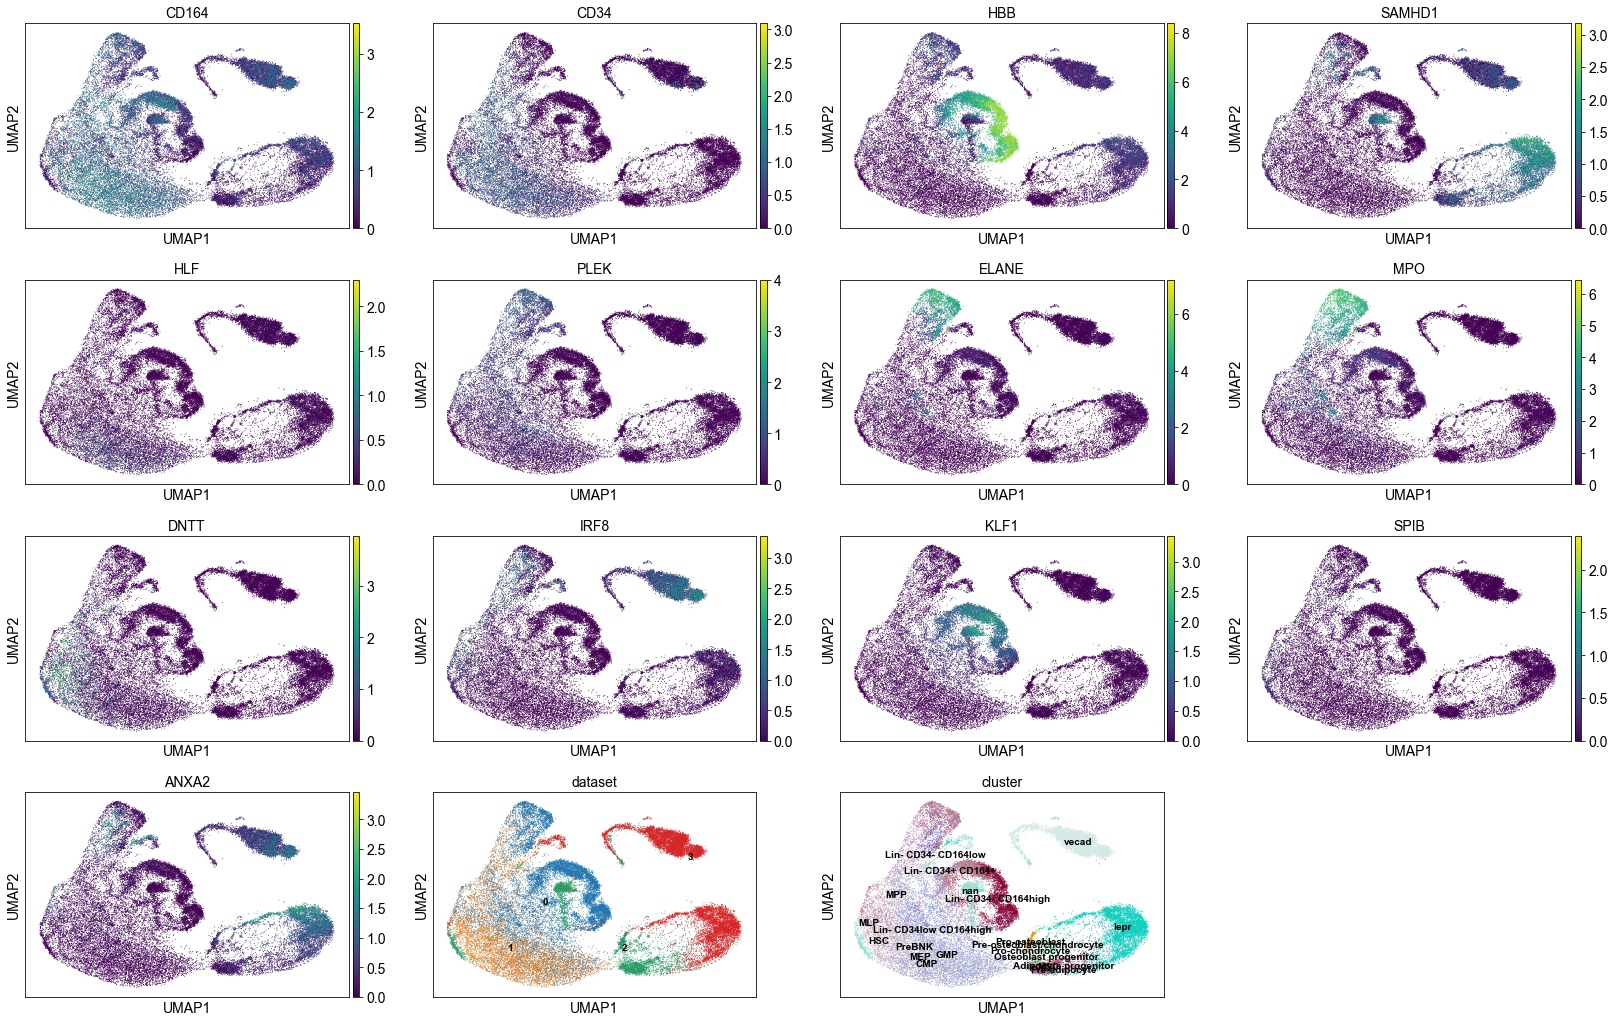

In [53]:
genes = set(adata_bbknn.raw.var.index.tolist()).intersection(pellin_lineage()['Gene Symbol'].tolist())
sc.pl.umap(adata_bbknn, color = list(genes) + ['KLF1', 'SPIB','ANXA2','dataset','cluster'], use_raw = True, legend_loc = 'on data') # many genes disappear

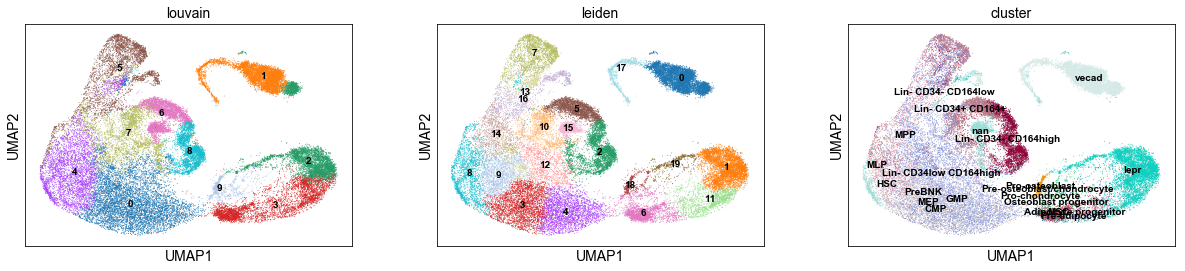

In [55]:
sc.pl.umap(adata_bbknn, color = ['louvain','leiden', 'cluster'], use_raw = True, legend_loc = 'on data')

# subcluster analysis

In [63]:
vecad = adata_bbknn[adata_bbknn.obs.loc[adata_bbknn.obs['louvain']=='1'].index, :] #sinusoid

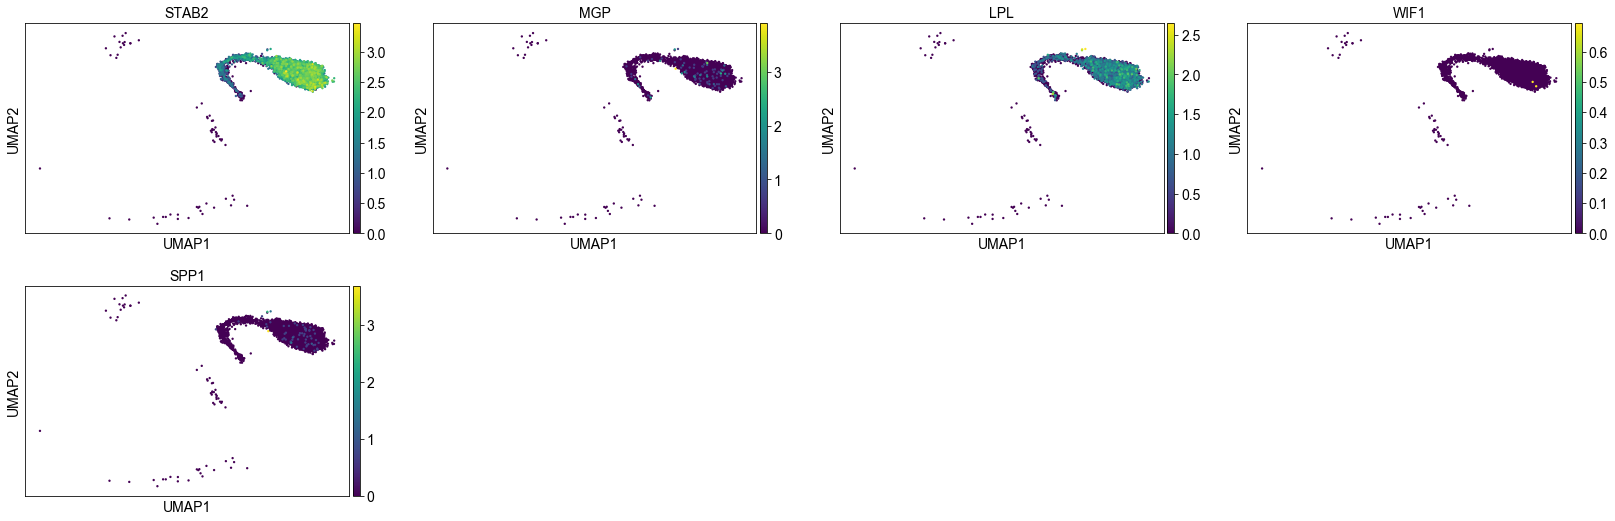

In [64]:
sc.pl.umap(vecad, color = ['STAB2', 'MGP', 'LPL', 'WIF1', 'SPP1'], use_raw = True)

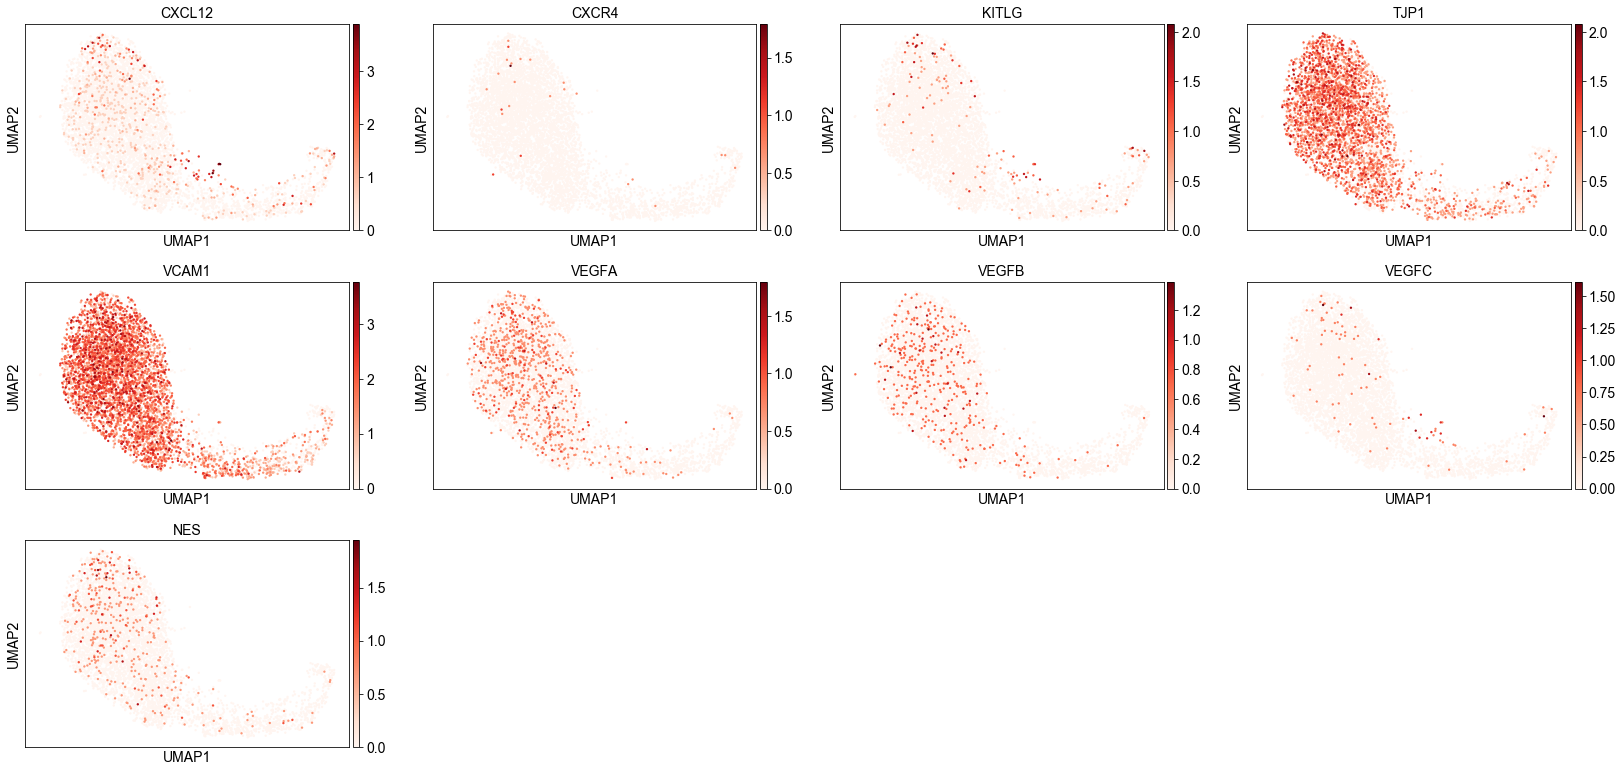

In [124]:
sc.pl.umap(vecad, color = ['CXCL12', 'CXCR4', 'KITLG', 'TJP1', 'VCAM1', 'VEGFA','VEGFB', 'VEGFC', 'NES'], use_raw = True, color_map = 'Reds') # perisinusoidal niche, pericyte VCAM

In [93]:
sc.tl.umap(vecad)

# two clustering method
sc.tl.louvain(vecad)
sc.tl.leiden(vecad)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


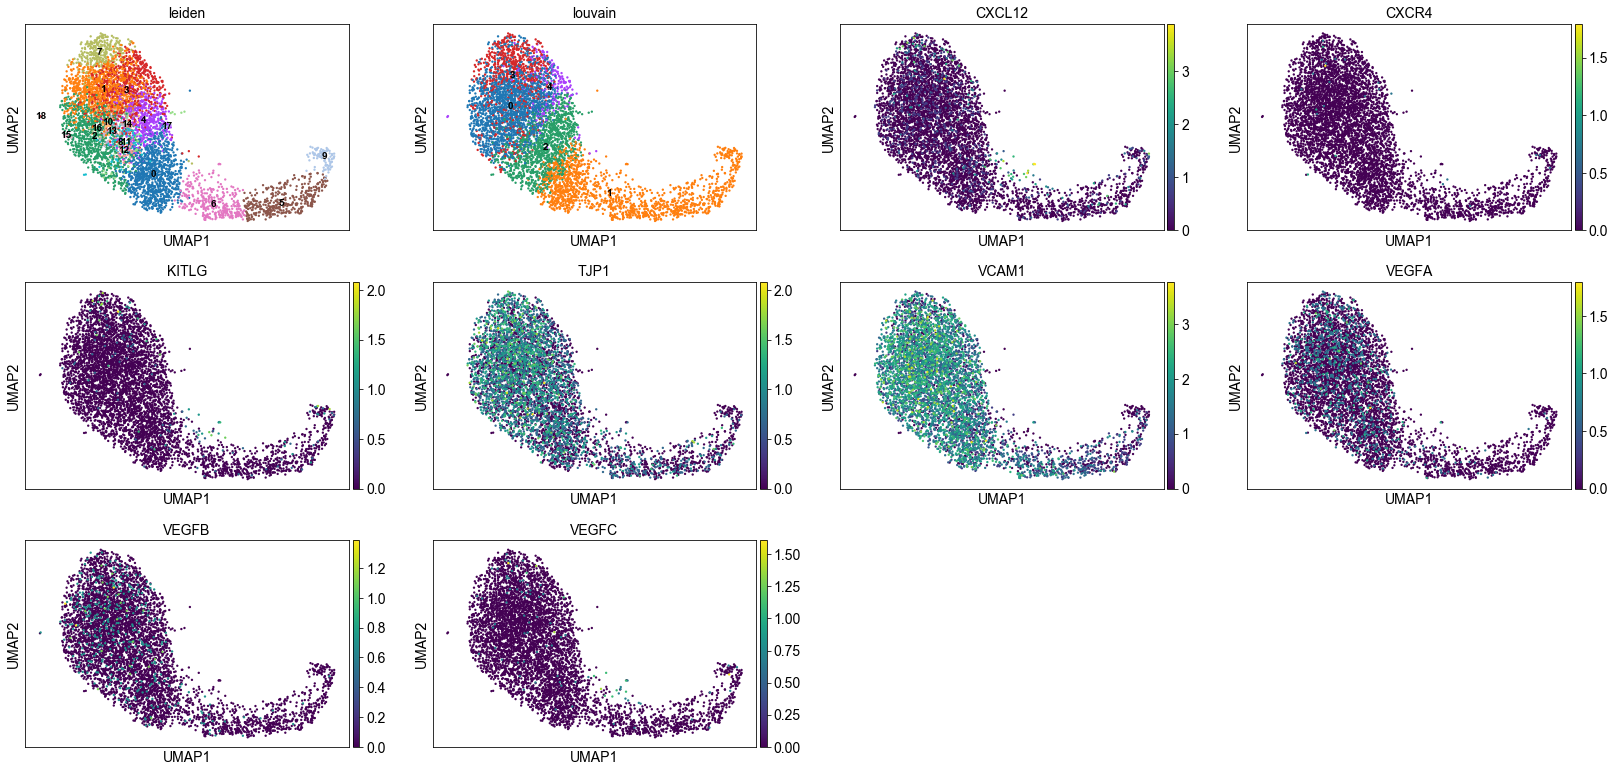

In [103]:
sc.pl.umap(vecad, color = ['leiden', 'louvain','CXCL12', 'CXCR4', 'KITLG', 'TJP1', 'VCAM1', 'VEGFA','VEGFB', 'VEGFC'], use_raw = True, legend_loc = 'on data') # perisinusoidal niche, VCAM

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)
Filtering genes using: min_in_group_fraction: 0.25 min_fold_change: 2, max_out_group_fraction: 0.5
categories: 0, 1, 2, etc.
var_group_labels: 11, 16, 18


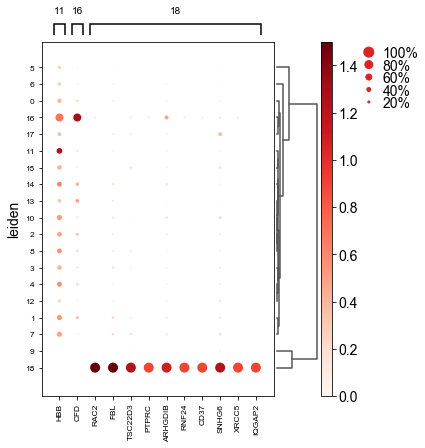

In [102]:
sc.tl.rank_genes_groups(vecad, groupby = 'leiden', use_raw=True)
sc.tl.filter_rank_genes_groups(vecad, groupby = 'leiden')
sc.pl.rank_genes_groups_dotplot(vecad, key = 'rank_genes_groups_filtered')

In [108]:
vecad.obs['louvain'].value_counts()

0    1901
1    1472
2    1111
3     766
4     216
Name: louvain, dtype: int64

In [109]:
vecad.obs['leiden'].value_counts()

0     1003
1      901
2      855
3      698
4      463
5      382
6      340
7      294
8      119
9       91
10      79
11      66
12      64
13      56
14      32
15      11
17       5
16       5
18       2
Name: leiden, dtype: int64

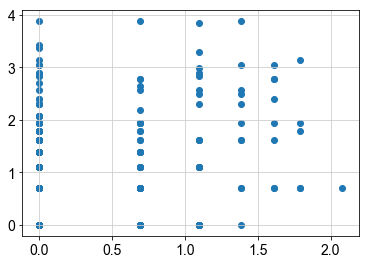

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
plt.scatter(vecad.raw[:, 'KITLG'].X, vecad.raw[:, 'CXCL12'].X) # no association

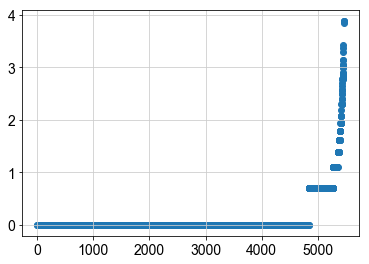

In [119]:
plt.scatter(np.arange(vecad.raw.X.shape[0]),np.sort(vecad.raw[:, 'CXCL12'].X))

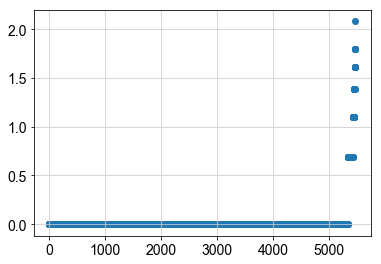

In [120]:
plt.scatter(np.arange(vecad.raw.X.shape[0]),np.sort(vecad.raw[:, 'KITLG'].X))

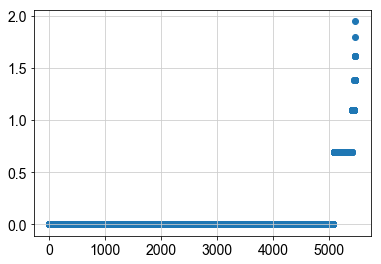

In [125]:
plt.scatter(np.arange(vecad.raw.X.shape[0]),np.sort(vecad.raw[:, 'NES'].X))

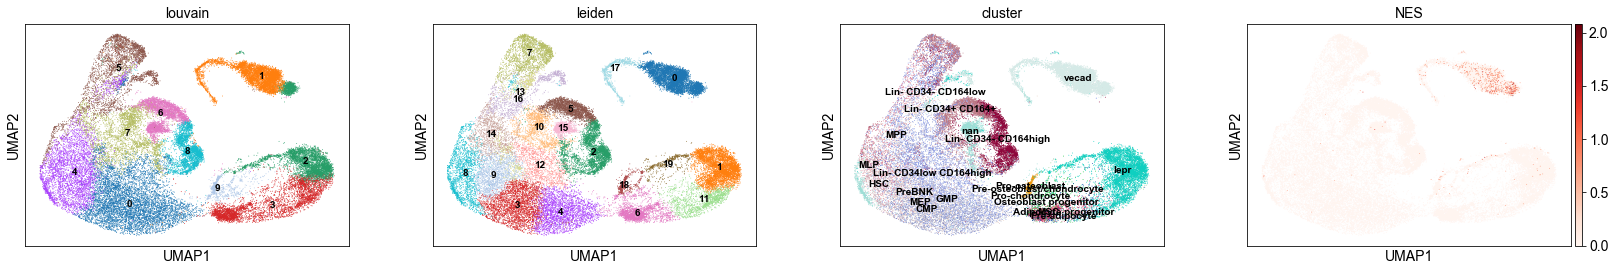

In [123]:
sc.pl.umap(adata_bbknn, color = ['louvain','leiden', 'cluster', 'NES'], use_raw = True, legend_loc = 'on data', color_map = "Reds") # Nestin arteriole

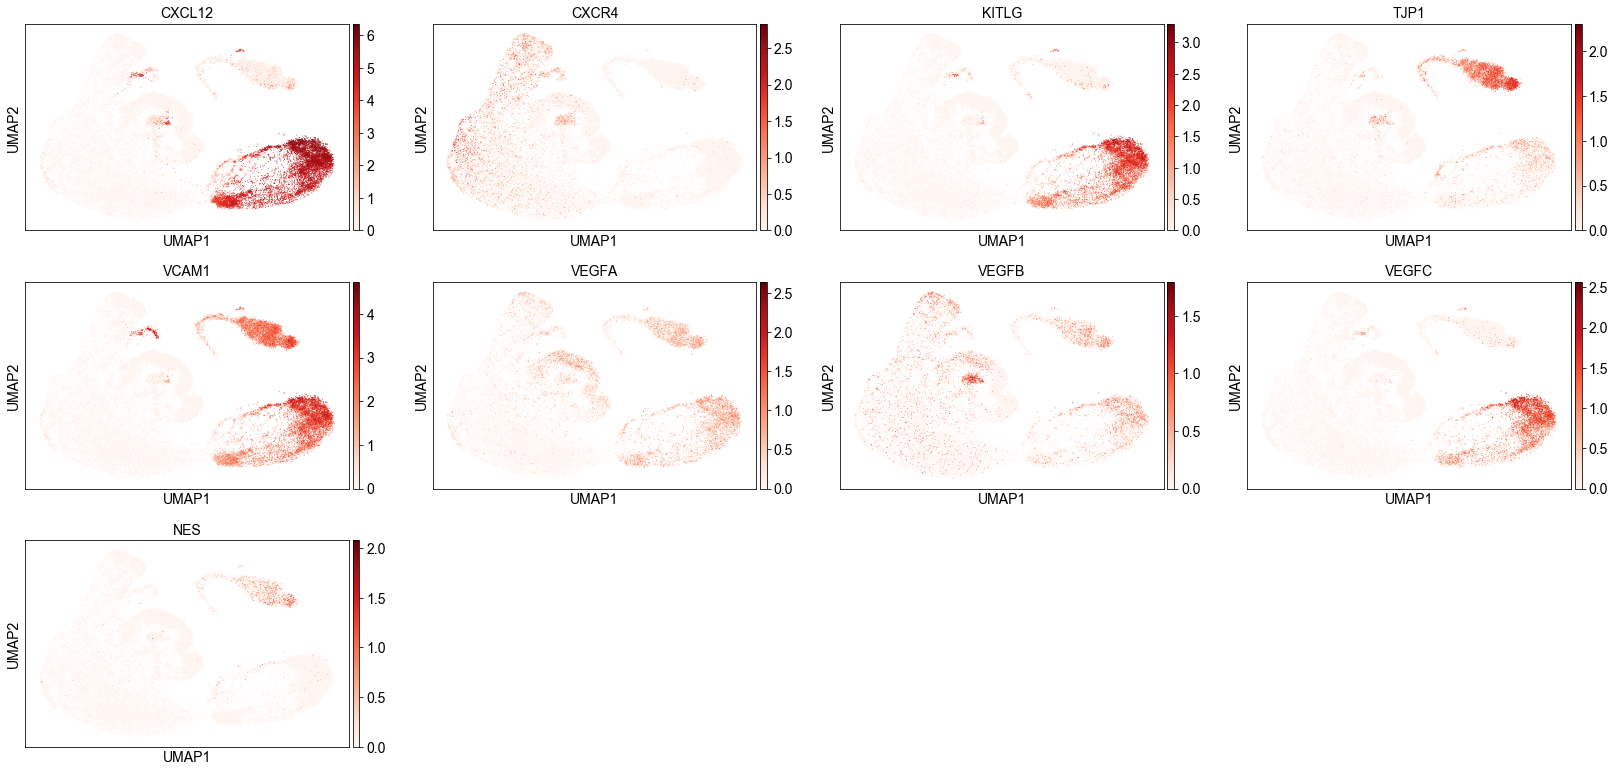

In [126]:
sc.pl.umap(adata_bbknn, color = ['CXCL12', 'CXCR4', 'KITLG', 'TJP1', 'VCAM1', 'VEGFA','VEGFB', 'VEGFC', 'NES'], use_raw = True, legend_loc = 'on data', color_map = "Reds") # Nestin arteriole

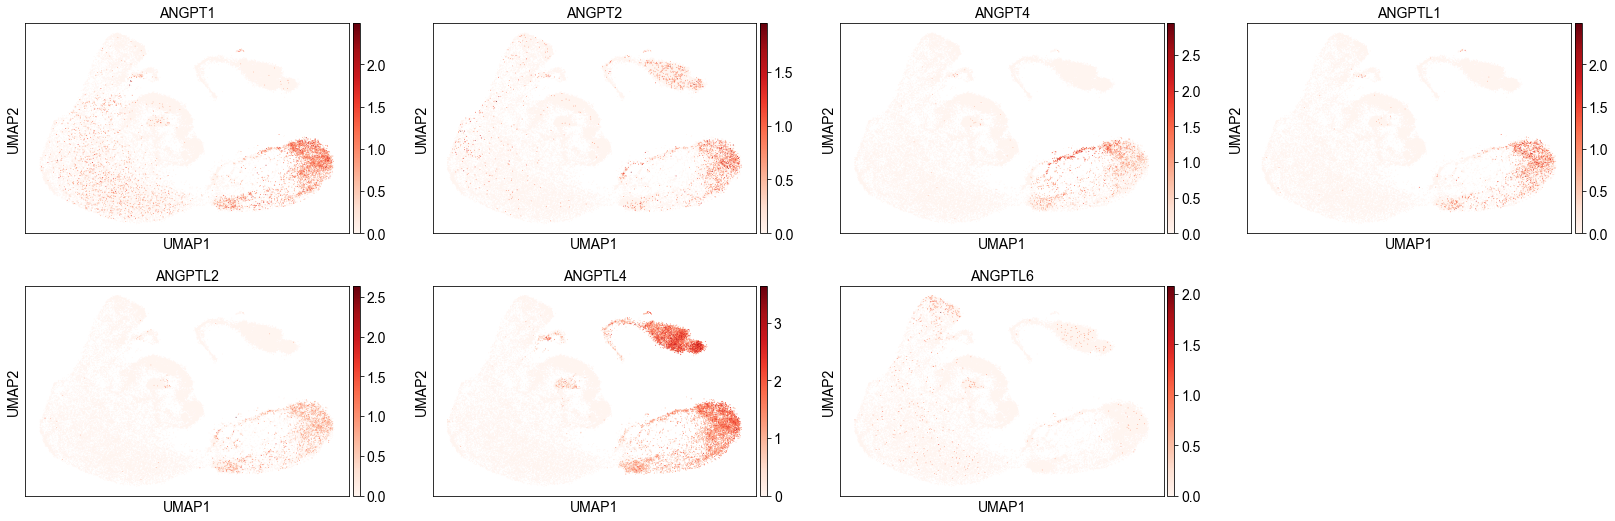

In [131]:
angpt = adata_bbknn.raw.var.loc[adata_bbknn.raw.var.index.str.startswith('ANGPT')].index.tolist()
sc.pl.umap(adata_bbknn, color = angpt, use_raw = True, legend_loc = 'on data', color_map = "Reds") # Nestin arteriole

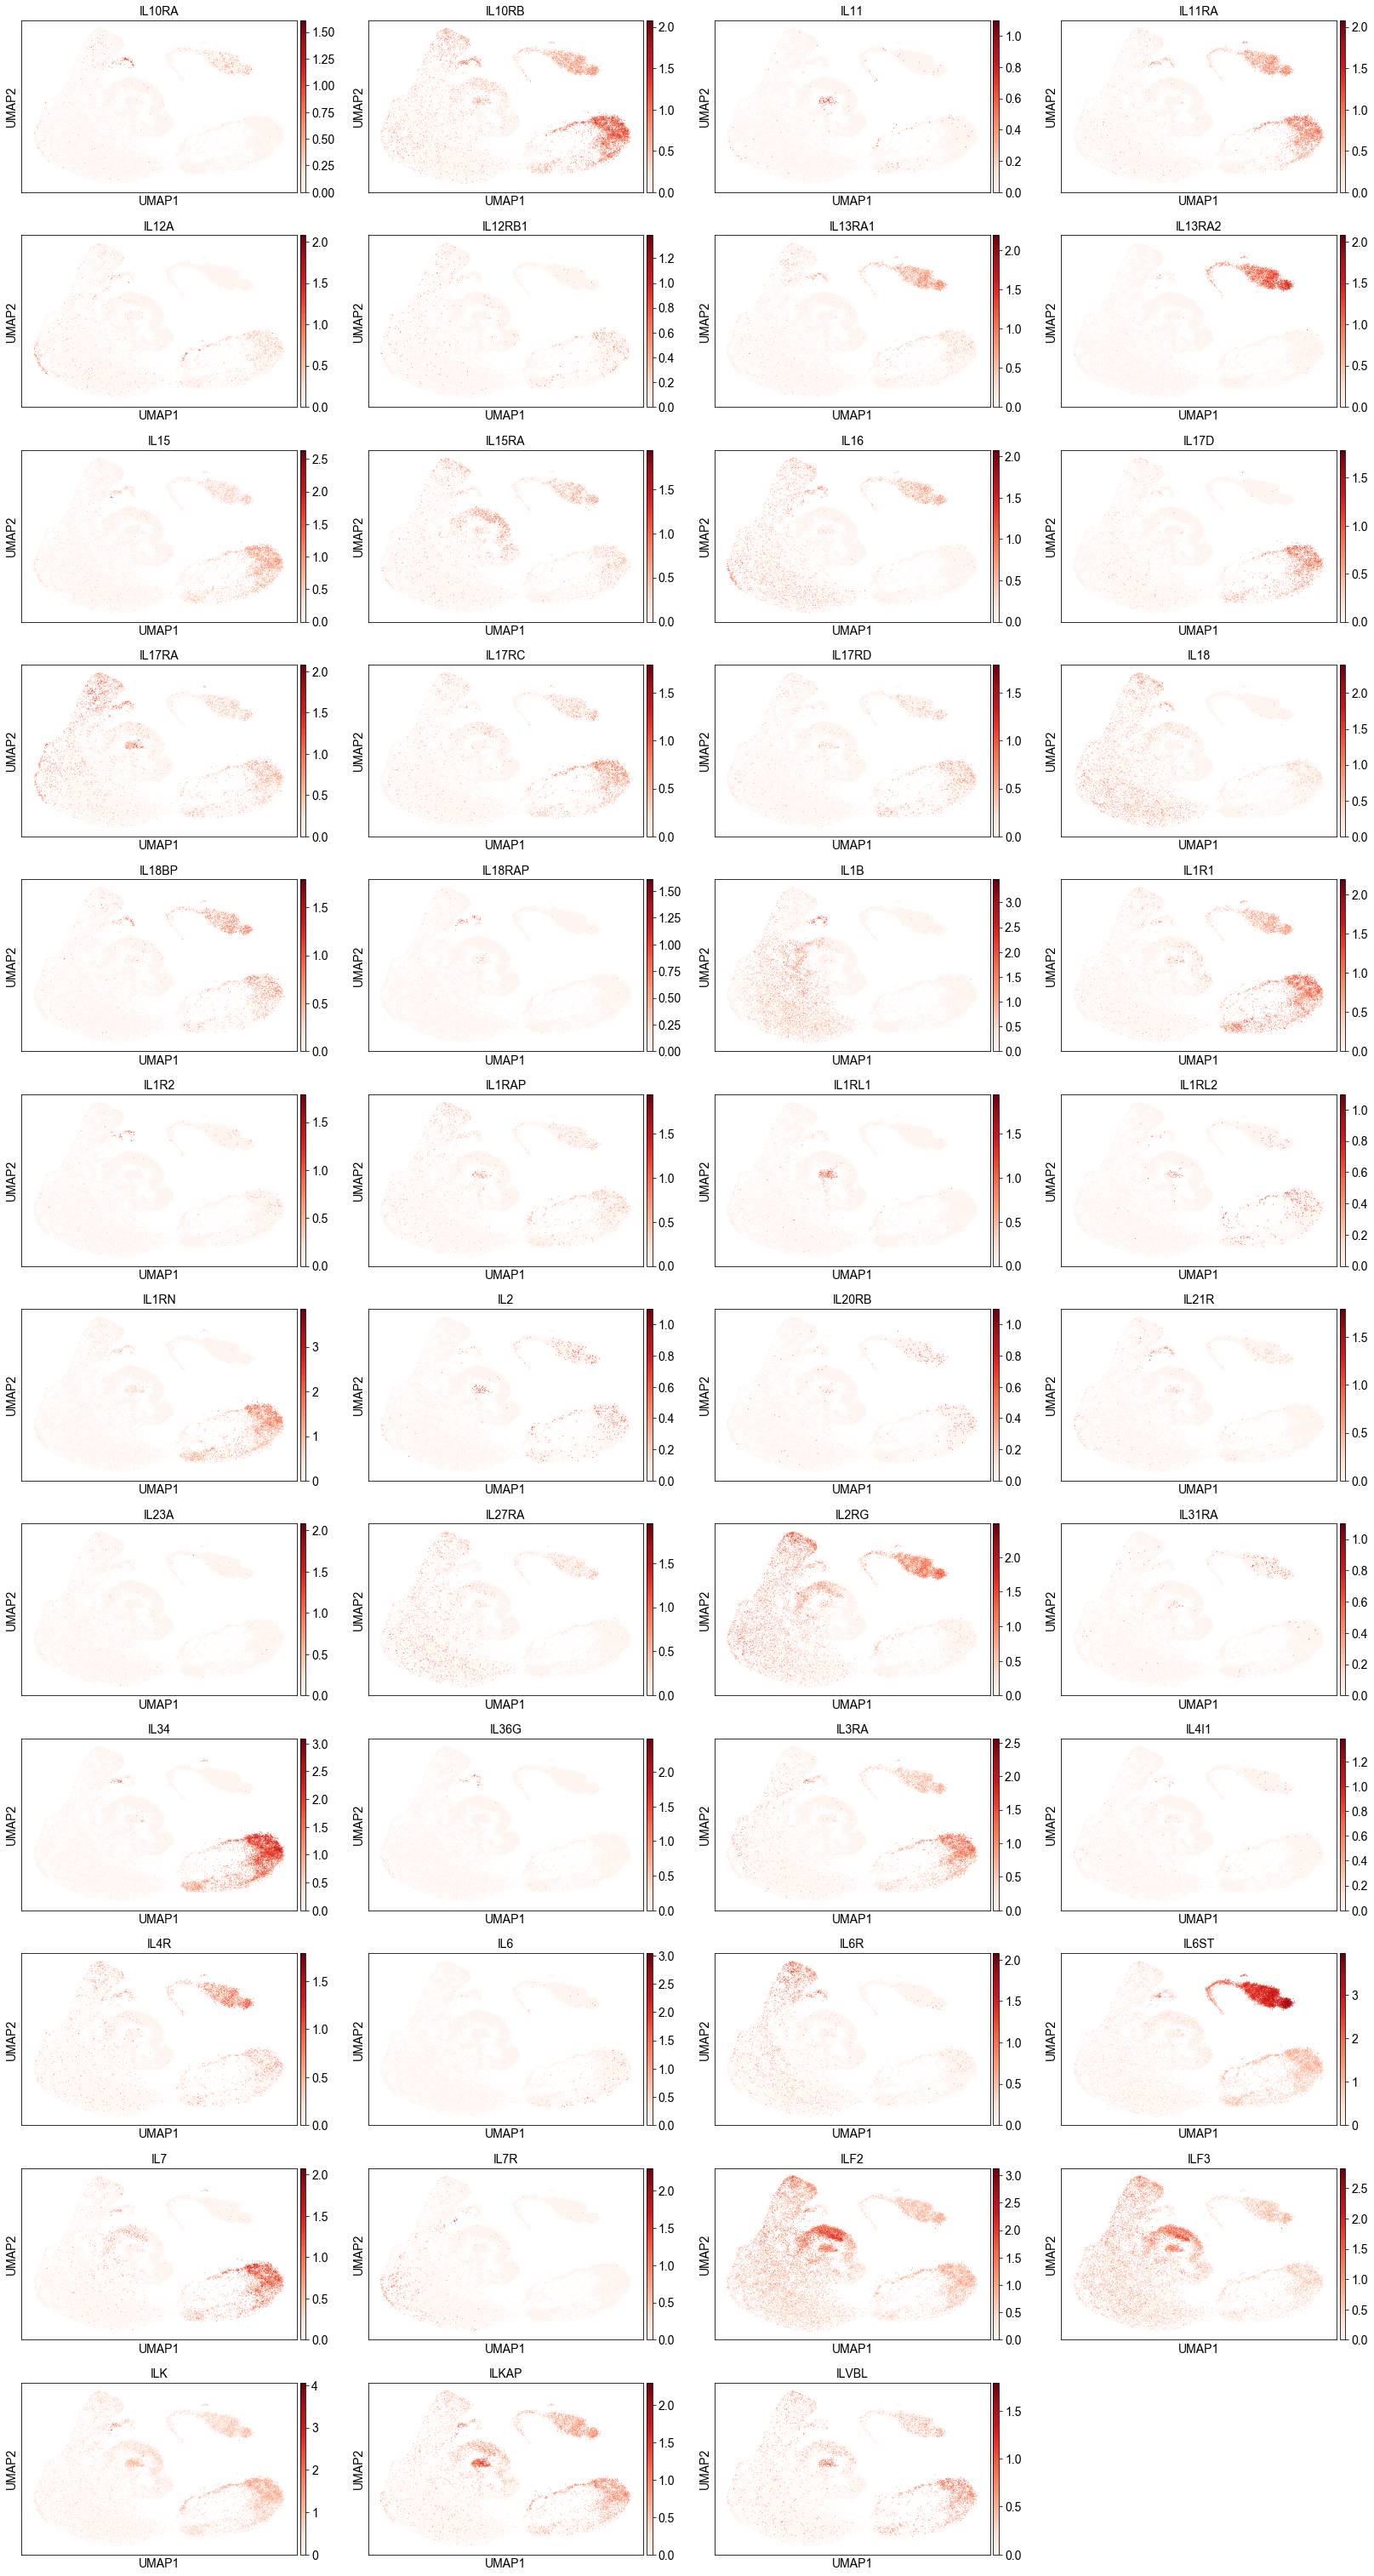

In [135]:
il = adata_bbknn.raw.var.loc[adata_bbknn.raw.var.index.str.startswith('IL')].index.tolist()
sc.pl.umap(adata_bbknn, color = il, use_raw = True, legend_loc = 'on data', color_map = "Reds") # Nestin arteriole